# 【補足】 異常部位検知 - AutoEncoder 

本章では AutoEncoder を用いた異常部位検知を紹介します。  
モデルの学習に大幅な時間を要します。そのためリアルタイムの講義では実装のポイントのみお伝えします。講義終了後に復習も兼ねて実装に挑戦してみてください。  
GPU 環境を推奨します。

![09](img/09.png)

今回はドイツのMVTec社が公開したデータセットを使用します。
[解説論文](https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/mvtec_ad.pdf)はコンピュータビジョンの世界トップ会議である CVPR 2019 で採択されています。

▼ データセット  
[URL](https://drive.google.com/open?id=1TV-b-qdN7YjUnowIx9_GKAQiOBlK9TMB)

## データセットの準備

In [1]:
# Zip ファイル解凍
!unzip -q ~~.zip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from glob import glob
train_img_paths = sorted(glob('/content/hazelnut/train/good/*.png'))
len(train_img_paths)

391

In [18]:
train_img_paths[:3]

['/content/hazelnut/train/good/000.png',
 '/content/hazelnut/train/good/001.png',
 '/content/hazelnut/train/good/002.png']

In [19]:
test_dirs = glob('/content/hazelnut/test/*')
test_img_paths = []
for dir in test_dirs:
    test_img_paths_ = sorted(glob(dir+'/*.png'))
    test_img_paths.extend(test_img_paths_)
len(test_img_paths)

110

In [20]:
test_img_paths[:3]

['/content/hazelnut/test/cut/000.png',
 '/content/hazelnut/test/cut/001.png',
 '/content/hazelnut/test/cut/002.png']

In [21]:
from PIL import Image

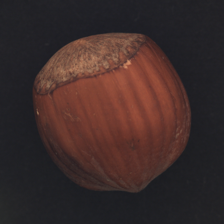

In [25]:
# 確認：正常データ
Image.open(train_img_paths[0]).convert('RGB').resize((224, 224))

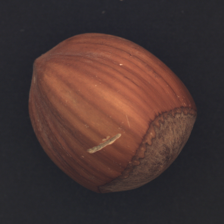

In [26]:
# 確認：異常データ
Image.open(test_img_paths[0]).convert('RGB').resize((224, 224))

In [27]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

In [33]:
# データセット作成
class Custom_Dataset(Dataset):

  def __init__(self,img_list):
    self.img_list = img_list
    self.prepocess = T.Compose([T.Resize((224, 224)), T.ToTensor()])
  
  def __getitem__(self,idx):
    img = Image.open(self.img_list[idx]).convert('RGB')
    img = self.prepocess(img)
    return img
  
  def __len__(self):
    return len(self.img_list)

In [39]:
# 正常データのみを使用する
train_list = train_img_paths[:int(len(train_img_paths)*0.8)]
val_list = train_img_paths[int(len(train_img_paths)*0.8):]
len(train_list), len(val_list)

(312, 79)

In [64]:
train_dataset = Custom_Dataset(train_list)
val_dataset = Custom_Dataset(val_list)
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

## モデル構築

In [65]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [66]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__() 
        self.Encoder = nn.Sequential(self.create_convblock(3, 16), 
                                     nn.MaxPool2d((2, 2)),
                                     self.create_convblock(16, 32),    
                                     nn.MaxPool2d((2,2)),
                                     self.create_convblock(32, 64),    
                                     nn.MaxPool2d((2, 2)),
                                     self.create_convblock(64, 128),   
                                     nn.MaxPool2d((2, 2)),
                                     self.create_convblock(128, 256),  
                                     nn.MaxPool2d((2, 2)),
                                     self.create_convblock(256, 512),  
                                    )
        self.Decoder = nn.Sequential(self.create_deconvblock(512, 256), 
                                     self.create_convblock(256, 256),
                                     self.create_deconvblock(256, 128), 
                                     self.create_convblock(128, 128),
                                     self.create_deconvblock(128, 64),  
                                     self.create_convblock(64, 64),
                                     self.create_deconvblock(64, 32),   
                                     self.create_convblock(32, 32),
                                     self.create_deconvblock(32, 16),   
                                     self.create_convblock(16, 16),
                                    )
        self.last_layer = nn.Conv2d(16, 3, 1, 1)
                                                               
    def create_convblock(self,i_fn,o_fn):
        conv_block = nn.Sequential(nn.Conv2d(i_fn, o_fn, 3, 1, 1),
                                   nn.BatchNorm2d(o_fn),
                                   nn.ReLU(),
                                   nn.Conv2d(o_fn, o_fn, 3, 1, 1),
                                   nn.BatchNorm2d(o_fn),
                                   nn.ReLU()
                                  )
        return conv_block

    def create_deconvblock(self, i_fn, o_fn):
        deconv_block = nn.Sequential(nn.ConvTranspose2d(i_fn, o_fn, kernel_size=2, stride=2),
                                      nn.BatchNorm2d(o_fn),
                                      nn.ReLU())
        return deconv_block

    def forward(self,x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        x = self.last_layer(x)           
        return x

In [70]:
from torchsummary import summary
model = AutoEncoder().to('cuda')
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
         MaxPool2d-7         [-1, 16, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           4,640
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           9,248
      BatchNorm2d-12         [-1, 32, 112, 112]              64
             ReLU-13         [-1, 32, 112, 112]               0
        MaxPool2d-14           [-1, 32,

In [1]:
epoch_num = 500
device = 'cuda'

best_loss = None
model = AutoEncoder().to(device)
limit_epoch = 100

optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
loss_list = {'train': [], 'val': []}

counter = 0
for e in range(epoch_num):
    total_loss = 0
    model.train()
    with tqdm(train_loader) as pbar:
        for itr , data in enumerate(pbar):
            optimizer.zero_grad()
            data = data.to(device)
            output = model(data)
            loss = criterion(output , data)
            total_loss += loss.detach().item()
            pbar.set_description(f'[train] Epoch {e+1:03}/{epoch_num:03} Itr {itr+1:02}/{len(pbar):02} Loss {total_loss/(itr+1):.3f}')
            loss.backward()
            optimizer.step()
    
    loss_list['train'].append(total_loss)
    total_loss = 0
    model.eval()
    with tqdm(val_loader) as pbar:
        for itr, data in enumerate(pbar):
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output , data)
            total_loss += loss.detach().item()
            pbar.set_description(f'[ val ] Epoch {e+1:03}/{epoch_num:03} Itr {itr+1:02}/{len(pbar):02} Loss {total_loss/(itr+1):.3f}')
    
    if best_loss is None or best_loss > total_loss/(itr+1):
        if best_loss is not None:
            print(f'update best_loss {best_loss:.6f} to {total_loss/(itr+1):.6f}')
        best_loss = total_loss/(itr+1)
        model_path = 'AutoEncoder_model.pth'
        torch.save(model.state_dict(), model_path)
        counter = 0
    else:
        counter += 1
        if limit_epoch <= counter:
            break
    loss_list['val'].append(total_loss)

## 再構成誤差の目視確認

In [72]:
import cv2

In [74]:
# 推論：正常データ
margin_w = 10

pretrained_model = AutoEncoder().cuda()
model_path = '/content/AutoEncoder_model.pth'
pretrained_model.load_state_dict(torch.load(model_path))
preprocess = T.Compose([T.Resize((224, 224)), T.ToTensor()])
pretrained_model.eval()
good_loss_list = []
for path in tqdm(val_list):
    img = Image.open(path).convert('RGB')
    img = preprocess(img).unsqueeze(0).cuda()
    with torch.no_grad():
        output = pretrained_model(img)[0]
    output = output.cpu().numpy().transpose(1, 2, 0)
    output = np.uint8(np.maximum(np.minimum(output*255, 255), 0))
    origin = np.uint8(img[0].cpu().numpy().transpose(1, 2, 0)*255)

    # 再構成誤差
    diff = np.uint8(np.abs(output.astype(np.float32) - origin.astype(np.float32)))
    good_loss_list.append(np.sum(diff))

    # 可視化
    heatmap = cv2.applyColorMap(diff, cv2.COLORMAP_JET)
    margin = np.ones((diff.shape[0], margin_w, 3))*255
    result = np.concatenate([origin[:,:,::-1], margin, output[:,:,::-1], margin, heatmap], axis=1)
    out_path = path.split('/')[-2] + '_' + path.split('/')[-1]
    cv2.imwrite(out_path, result)

100%|██████████| 79/79 [00:05<00:00, 14.91it/s]


In [75]:
# 推論：異常データ
margin_w = 10

pretrained_model = AutoEncoder().cuda()
model_path = '/content/AutoEncoder_model.pth'
pretrained_model.load_state_dict(torch.load(model_path))
preprocess = T.Compose([T.Resize((224, 224)), T.ToTensor()])
pretrained_model.eval()
anomaly_loss_list = []
for path in tqdm(test_img_paths):
    img = Image.open(path).convert('RGB')
    img = preprocess(img).unsqueeze(0).cuda()
    with torch.no_grad():
        output = pretrained_model(img)[0]
    output = output.cpu().numpy().transpose(1, 2, 0)
    output = np.uint8(np.maximum(np.minimum(output*255, 255), 0))
    origin = np.uint8(img[0].cpu().numpy().transpose(1, 2, 0)*255)

    # 再構成誤差
    diff = np.uint8(np.abs(output.astype(np.float32) - origin.astype(np.float32)))
    anomaly_loss_list.append(np.sum(diff))

    # 可視化
    heatmap = cv2.applyColorMap(diff, cv2.COLORMAP_JET)
    margin = np.ones((diff.shape[0], margin_w, 3))*255
    result = np.concatenate([origin[:,:,::-1], margin, output[:,:,::-1], margin, heatmap], axis=1)
    out_path = path.split('/')[-2] + '_' + path.split('/')[-1]
    cv2.imwrite(out_path, result)

100%|██████████| 110/110 [00:07<00:00, 15.04it/s]


以下のように異常データが入力された場合にうまく復元ができず、異常部位の再構成誤差が際立っていれば成功です。

![result](img/crack_008.png)

生成モデルを用いた異常検知は再構成誤差にしきい値を設けて、異常判定を行います。  
再構成誤差の分布の確認や上画像のように目視によるチェックも必要なことを覚えておきましょう。